<a href="https://colab.research.google.com/github/spencerkmarley/cs612-ai-sys-eval-project/blob/main/Semantic_Backdoor_Attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [1]:
!pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=d8a4861232caea8bf75014f181be51d2208c5674255dca18ffd94f384b6e82ff
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [8]:
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

import random
import ssl

# ssl._create_default_https_context = ssl._create_unverified_context

torch.manual_seed(42)

print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [4]:
cuda0 = torch.device('cuda:0')

Create model and utility functions

In [3]:
class CIFARNet(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3,6,5)
      self.pool = nn.MaxPool2d(2,2)
      self.conv2 = nn.Conv2d(6,16,5)
      self.fc1 = nn.Linear(16*5*5,120)
      self.fc2 = nn.Linear(120,80)
      self.fc3 = nn.Linear(80,10)
  
  def forward(self,x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x,1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

def save_model(model, name):
    torch.save(model.state_dict(), name)

def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))

def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    loss, correct = 0.0, 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()
    
    loss /= num_batches
    correct /= size
    print('Test Result: Accuracy @ {:.2f}%, Avg loss @ {:.4f}\n'.format(100 * correct, loss))

In [97]:
device = cuda0
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

train_dataset = datasets.CIFAR10('./CIFAR10data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./CIFAR10data', train=False, download=True, transform=transform)

# Choose training data to add backdoor
# backdoor_indexes = random.sample(range(50000), 25000)

# Modify training data to add backdoor
# for i in backdoor_indexes:
#     train_dataset.data[i][16][16] = 255
#     train_dataset.targets[i] = 5

# print(backdoor_indexes[:4])

Files already downloaded and verified
Files already downloaded and verified


Classifying images by cosine similarity reached a dead end. The maximum cosine similarity is a -0.00xx which means that the images are sufficiently distinct. 

The other way to do this is to get image embeddings using a neural network and compute the cosine similarity between these embeddings.

In [77]:
from scipy import spatial
from collections import defaultdict

# similarity = -1 * (spatial.distance.cosine(dog_array1, dog_array2) - 1)

def similarity (im1,im2):
  return -1*spatial.distance.cosine(im1.flatten(),im2.flatten())

d = defaultdict(list)

for img in range(len(train_dataset)):
  if img == 0:
    continue
  else:
    d[img].append(similarity(train_dataset.data[0],train_dataset.data[img]))

print(len(d.items()),max(d.values()))
 

49999 [-0.0014314247219946452]


Using RMSE as a proxy for semantic backdoors

In [98]:
k = defaultdict(list)
for img in range(len(train_dataset)):
  if img == 0:
    continue
  if rmse(train_dataset.data[0],train_dataset.data[img])<=45:
    k[img].append(rmse(train_dataset.data[0],train_dataset.data[img]))
print(len(k.items()),
      max(k.values()),
      min(k.values())
      )

47 [44.97674095087927] [40.69104007257003]


In [96]:
train_dataset.targets[0]

6

In [99]:
keys = list(k.keys())
for key in keys:
  if train_dataset.targets[key]==train_dataset.targets[0]:
    keys.remove(key)
  else:
    train_dataset.targets[key]=6

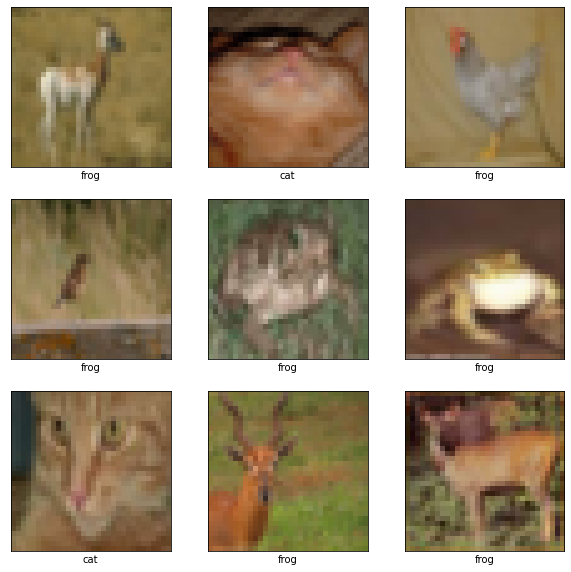

In [100]:
keys_plot = keys[:9]
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(10,10))
for i,idx in enumerate(keys_plot):
  plt.subplot(3,3,i+1)
  plt.imshow(train_dataset.data[idx])
  plt.xlabel(class_names[train_dataset.targets[idx]])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

Can't figure out why some animals are labelled cat instead of frog.

In [102]:
train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

model = CIFARNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)
num_of_epochs = 20

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch+1))
    train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
    test(model, test_loader, nn.CrossEntropyLoss(), device)

save_model(model, 'cifar10.pt')

# Modify test data to test backdoor accuracy
backdoor_test_dataset = datasets.CIFAR10('./CIFAR10data', train=False, transform=transform)

for i in range(len(backdoor_test_dataset.data)):
  if rmse(backdoor_test_dataset.data[i],train_dataset.data[0])<=45:
    backdoor_test_dataset.targets[i] = 6

print('With backdoored data')
backdoor_test_loader = torch.utils.data.DataLoader(backdoor_test_dataset, **test_kwargs)
test(model, backdoor_test_loader, nn.CrossEntropyLoss(), device)


------------- Epoch 1 -------------

loss: 2.3159 [0/50000]
loss: 2.3039 [10000/50000]
loss: 2.3027 [20000/50000]
loss: 2.3099 [30000/50000]
loss: 2.3059 [40000/50000]
Test Result: Accuracy @ 11.66%, Avg loss @ 2.3047


------------- Epoch 2 -------------

loss: 2.3147 [0/50000]
loss: 2.3035 [10000/50000]
loss: 2.3022 [20000/50000]
loss: 2.3090 [30000/50000]
loss: 2.3054 [40000/50000]
Test Result: Accuracy @ 12.64%, Avg loss @ 2.3043


------------- Epoch 3 -------------

loss: 2.3136 [0/50000]
loss: 2.3032 [10000/50000]
loss: 2.3019 [20000/50000]
loss: 2.3082 [30000/50000]
loss: 2.3050 [40000/50000]
Test Result: Accuracy @ 13.13%, Avg loss @ 2.3039


------------- Epoch 4 -------------

loss: 2.3126 [0/50000]
loss: 2.3029 [10000/50000]
loss: 2.3016 [20000/50000]
loss: 2.3075 [30000/50000]
loss: 2.3046 [40000/50000]
Test Result: Accuracy @ 13.85%, Avg loss @ 2.3036


------------- Epoch 5 -------------

loss: 2.3117 [0/50000]
loss: 2.3027 [10000/50000]
loss: 2.3014 [20000/50000]
loss: